In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from venn_abers import VennAbersCalibrator

In [2]:
def get_truncated_normal(mean, std, low=0, high=1):
    return truncnorm((low - mean) / std, (high - mean) / std, loc=mean, scale=std)

def _logit(p, eps=1e-12):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p) - np.log(1 - p)

def platt_fit_predict(s_cal, y_cal, s_test, l2=1e-6):
    z = _logit(s_cal)
    def nll(ab):
        A, B = ab
        p = 1.0 / (1.0 + np.exp(-(A * z + B)))
        return log_loss(y_cal, p) + l2 * (A*A + B*B)
    res = minimize(nll, x0=np.array([1.0, 0.0]), method="L-BFGS-B")
    A_opt, B_opt = res.x
    z_test = _logit(s_test)
    p_test = 1.0 / (1.0 + np.exp(-(A_opt * z_test + B_opt)))
    return p_test, (A_opt, B_opt, res)

def ece_quantile(y, p, n_bins=10):
    pt, pp = calibration_curve(y, p, n_bins=n_bins, strategy="quantile")
    return float(np.mean(np.abs(pt - pp))), pt, pp

# --- Simulation with truncated normals ---
def run_truncnorm_simulation(mean0, std0, mean1, std1, counts, title):
    rng = np.random.default_rng(42)
    
    # Generate truncated normal scores
    pdf0 = get_truncated_normal(mean0, std0)
    pdf1 = get_truncated_normal(mean1, std1)
    
    scores_0 = pdf0.rvs(counts[0])
    scores_1 = pdf1.rvs(counts[1])
    
    targets_0 = np.zeros(counts[0])
    targets_1 = np.ones(counts[1])
    
    df_sim = pd.DataFrame({
        "target": np.concatenate([targets_0, targets_1]),
        "score": np.concatenate([scores_0, scores_1])
    }).sample(frac=1, random_state=42).reset_index(drop=True)
    
    print(f"\n=== {title} ===")
    print(df_sim.groupby("target")["score"].describe())
    
    # ---- Calibration split ----
    X_cal, X_test, y_cal, y_test = train_test_split(
        df_sim[["score"]].values, df_sim["target"].values,
        test_size=0.3, stratify=df_sim["target"].values, random_state=42
    )
    s_cal, s_test = X_cal.ravel(), X_test.ravel()
    
    # ---- Platt ----
    p_platt_test, _ = platt_fit_predict(s_cal, y_cal, s_test)
    p_platt_cal, _  = platt_fit_predict(s_cal, y_cal, s_cal)
    
    # ---- Isotonic ----
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(s_cal, y_cal)
    p_iso_test, p_iso_cal = iso.predict(s_test), iso.predict(s_cal)
    
    # ---- Venn-Abers ----
    p_cal_2d  = np.column_stack([1 - s_cal,  s_cal])
    p_test_2d = np.column_stack([1 - s_test, s_test])
    va = VennAbersCalibrator()
    p_va_test = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                 p_test=p_test_2d, p0_p1_output=False)[:,1]
    p_va_cal = va.predict_proba(p_cal=p_cal_2d, y_cal=y_cal,
                                p_test=p_cal_2d, p0_p1_output=False)[:,1]
    
    # ---- Results ----
    methods_test = {
        "Raw": s_test,
        "Platt": p_platt_test,
        "Isotonic": p_iso_test,
        "Venn-Abers-IVAP": p_va_test,
    }
    methods_cal = {
        "Raw": s_cal,
        "Platt": p_platt_cal,
        "Isotonic": p_iso_cal,
        "Venn-Abers-IVAP": p_va_cal,
    }
    
    def evaluate(methods, y, setname):
        rows = []
        for name, p in methods.items():
            ece, _, _ = ece_quantile(y, p, n_bins=10)
            rows.append({
                "Method": name,
                "LogLoss": log_loss(y, p),
                "Brier": brier_score_loss(y, p),
                "ROC_AUC": roc_auc_score(y, p),
                "ECE": ece,
            })
        df = pd.DataFrame(rows).set_index("Method").round(4)
        print(f"\nCalibration Metrics ({setname} set):")
        display(df)
    
    # --- Metrics ---
    evaluate(methods_cal,  y_cal,  "Calibration")
    evaluate(methods_test, y_test, "Test")
    
    # --- Calibration curves ---
    plt.figure(figsize=(6,6))
    for name, p in methods_cal.items():
        _, pt, pp = ece_quantile(y_cal, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Calibration set) - {title}")
    plt.legend(); plt.grid(True); plt.show()
    
    plt.figure(figsize=(6,6))
    for name, p in methods_test.items():
        _, pt, pp = ece_quantile(y_test, p, n_bins=10)
        plt.plot(pp, pt, marker='o', label=name)
    plt.plot([0,1],[0,1],'--',color='gray')
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(f"Calibration Curves (Test set) - {title}")
    plt.legend(); plt.grid(True); plt.show()





=== TruncNorm Simulation with imbalance ===
          count      mean       std       min       25%       50%       75%   
target                                                                        
0.0     25473.0  0.205285  0.094015  0.000015  0.137826  0.202820  0.269005  \
1.0      7108.0  0.744059  0.157004  0.089427  0.641859  0.762294  0.866983   

             max  
target            
0.0     0.643876  
1.0     0.999890  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2555,0.0595,0.9964,0.1940
Platt,0.0471,0.0118,0.9964,0.0033
Isotonic,0.0444,0.0115,0.9966,0.0000
Venn-Abers-IVAP,0.0450,0.0115,0.9966,0.0012



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2559,0.0596,0.9956,0.1935
Platt,0.0490,0.0116,0.9956,0.0033
Isotonic,0.0479,0.0117,0.9954,0.0016
Venn-Abers-IVAP,0.0478,0.0117,0.9956,0.0012


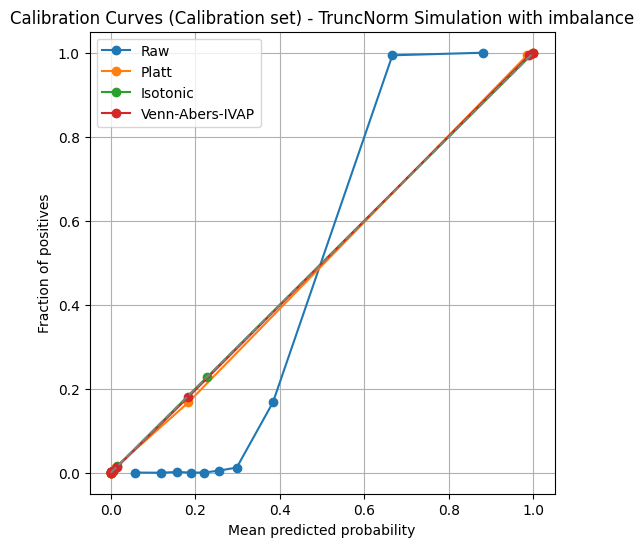

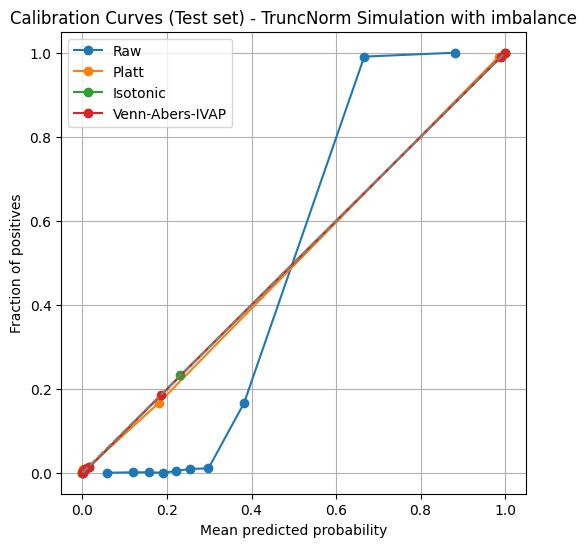


=== TruncNorm Simulation with balance ===
          count      mean       std      min       25%       50%       75%   
target                                                                       
0.0     10000.0  0.204988  0.094060  0.00055  0.138008  0.203131  0.268828  \
1.0     10000.0  0.741959  0.157861  0.06540  0.639508  0.758540  0.865547   

             max  
target            
0.0     0.582516  
1.0     0.999950  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2790,0.0704,0.9959,0.2021
Platt,0.0702,0.0183,0.9959,0.0040
Isotonic,0.0656,0.0177,0.9961,0.0000
Venn-Abers-IVAP,0.0666,0.0178,0.9961,0.0024



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.2859,0.0730,0.9958,0.2052
Platt,0.0741,0.0201,0.9958,0.0049
Isotonic,0.0727,0.0198,0.9957,0.0016
Venn-Abers-IVAP,0.0732,0.0198,0.9957,0.0030


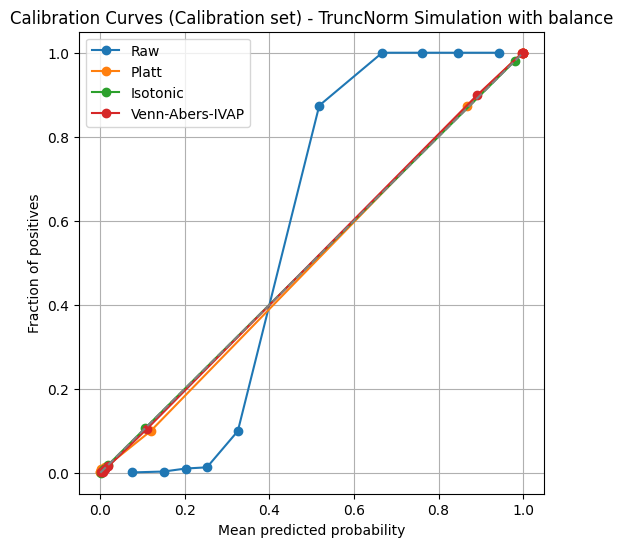

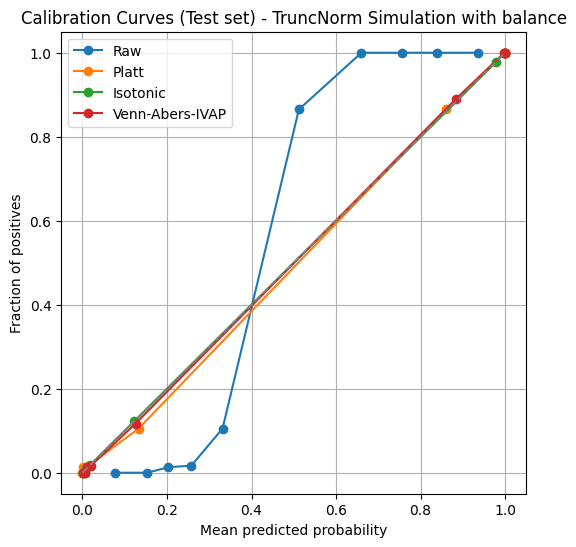


=== TruncNorm Simulation with imbalance (reversed) ===
          count      mean       std       min       25%       50%       75%   
target                                                                        
0.0      7108.0  0.207067  0.094024  0.000003  0.139216  0.204399  0.270471  \
1.0     25473.0  0.741281  0.160029  0.056617  0.635782  0.758449  0.867290   

             max  
target            
0.0     0.627981  
1.0     0.999983  

Calibration Metrics (Calibration set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3094,0.0841,0.9951,0.2173
Platt,0.0735,0.0197,0.9951,0.0043
Isotonic,0.0670,0.0190,0.9952,0.0000
Venn-Abers-IVAP,0.0676,0.0190,0.9952,0.0014



Calibration Metrics (Test set):


,LogLoss,Brier,ROC_AUC,ECE
Method,,,,
Raw,0.3056,0.0825,0.9953,0.2135
Platt,0.0706,0.0198,0.9953,0.0036
Isotonic,0.0678,0.0194,0.9952,0.0051
Venn-Abers-IVAP,0.0681,0.0194,0.9952,0.0025


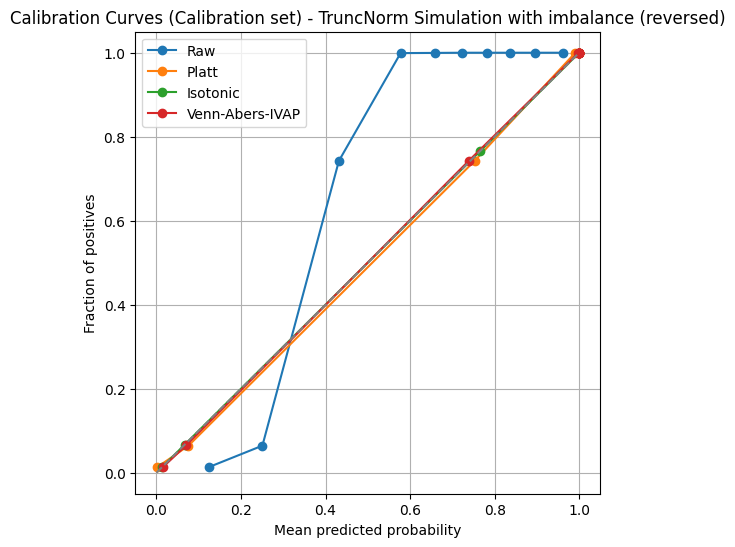

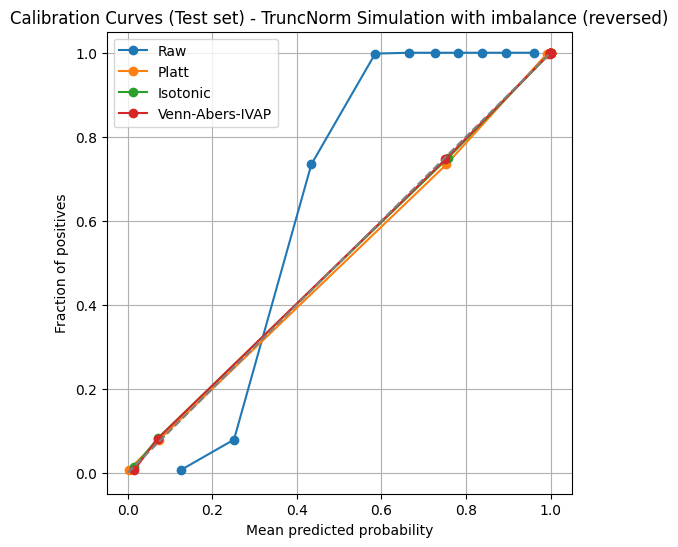

In [3]:
# Original distribution (imbalanced)

run_truncnorm_simulation(mean0=0.2, std0=0.1, mean1=0.8, std1=0.2, counts=(25473, 7108), title="TruncNorm Simulation with imbalance")

# Balanced (equal classes)
run_truncnorm_simulation(mean0=0.2, std0=0.1, mean1=0.8, std1=0.2, counts=(10000, 10000), title="TruncNorm Simulation with balance")


# Reversed imbalance (1 >> 0)
run_truncnorm_simulation(mean0=0.2, std0=0.1, mean1=0.8, std1=0.2, counts=(7108, 25473), title="TruncNorm Simulation with imbalance (reversed)")
